# Facial Keypoint Detection
## W207 Final Project
### Summer 2019
### T. P. Goter



In [35]:
%matplotlib inline
import time
import pandas as pd
import numpy as  np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [36]:
# Load data from the CSV
df = pd.read_csv('facial-keypoints-detection/training.csv')

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# Data Exploration Begins
Let's start with simply looking at the data columns we have. We will then look for missing data.

In [37]:
def header(text):
    print(50*"=")
    print(text)
    print(50*"=")

In [38]:
header("Column Labels")
for c, col in enumerate(df.columns):
    print("Column {:d}: {}".format(c, col))
    

df_desc = df.describe()
desc_data = [df_desc.loc[label].values for label in df_desc.index ]
    
header("Dataframe Description")
header("Counts by Label")
print(df.describe().loc['count'])
header("Max Value by Label")
print(df.describe().loc['max'])
header("Min Value by Label")
print(df.describe().loc['min'])
header("Range of Values by Label")
print(df.describe().loc['max'] - df.describe().loc['min'])

Column Labels
Column 0: left_eye_center_x
Column 1: left_eye_center_y
Column 2: right_eye_center_x
Column 3: right_eye_center_y
Column 4: left_eye_inner_corner_x
Column 5: left_eye_inner_corner_y
Column 6: left_eye_outer_corner_x
Column 7: left_eye_outer_corner_y
Column 8: right_eye_inner_corner_x
Column 9: right_eye_inner_corner_y
Column 10: right_eye_outer_corner_x
Column 11: right_eye_outer_corner_y
Column 12: left_eyebrow_inner_end_x
Column 13: left_eyebrow_inner_end_y
Column 14: left_eyebrow_outer_end_x
Column 15: left_eyebrow_outer_end_y
Column 16: right_eyebrow_inner_end_x
Column 17: right_eyebrow_inner_end_y
Column 18: right_eyebrow_outer_end_x
Column 19: right_eyebrow_outer_end_y
Column 20: nose_tip_x
Column 21: nose_tip_y
Column 22: mouth_left_corner_x
Column 23: mouth_left_corner_y
Column 24: mouth_right_corner_x
Column 25: mouth_right_corner_y
Column 26: mouth_center_top_lip_x
Column 27: mouth_center_top_lip_y
Column 28: mouth_center_bottom_lip_x
Column 29: mouth_center_bot

## Results from Descriptive Summary
### Counts
There are up to 7039 training examples for some of the facial keypoints (e.g., left eye center) and as few as 2225 for others such as left eyebrows. Just by looking at the summary data it is unclear if this is because the image itself only shows part of a face or if those labels are just missing. Either way it would take too much time and effort to label ~5000 of the photos by hand. We will likely have to use just the data we have access to. If we build individual models for each keypoint coordinate, that would maximize our use of the training data.  
### Feature Ranges
The mins, maxs and ranges of x, y coordinates for our keypoints indicates that the images are far from centered. We only have 96 pixels and our ranges are on the order of 70 (obviously depending on which parameter we are looking at).  Perhaps we should try to plot up the image with the min and max of each parameter to understand the range of the images we are looking at. In fact, let's do that now.


In [39]:
# Create a mini-dataframe with only the most extreme facial keypoints
range_df = pd.DataFrame()
for col in df.columns[:-1]:
    range_df = pd.concat([range_df,
                          pd.DataFrame(df.iloc[df[col].idxmin()]).T,
                          pd.DataFrame(df.iloc[df[col].idxmax()]).T])

range_df['Image'] = range_df['Image'].map(lambda x: np.array(x.split()).astype(int) / 255.0)
print(range_df)

     left_eye_center_x left_eye_center_y right_eye_center_x  \
3563           22.7633           55.6172            1.52853   
6242           94.6893           68.1895            85.0394   
3212            53.641           1.61651            8.38784   
2915           87.6326           80.5026            81.8278   
3881            45.258           12.3727           0.686592   
6242           94.6893           68.1895            85.0394   
3212            53.641           1.61651            8.38784   
2915           87.6326           80.5026            81.8278   
3563           22.7633           55.6172            1.52853   
3943            92.623           63.5119            50.4149   
4988           66.9624            23.833            25.8718   
1541           74.2102           65.1957            45.4241   
3563           22.7633           55.6172            1.52853   
6201           84.8294           51.2493            43.8961   
4988           66.9624            23.833            25.

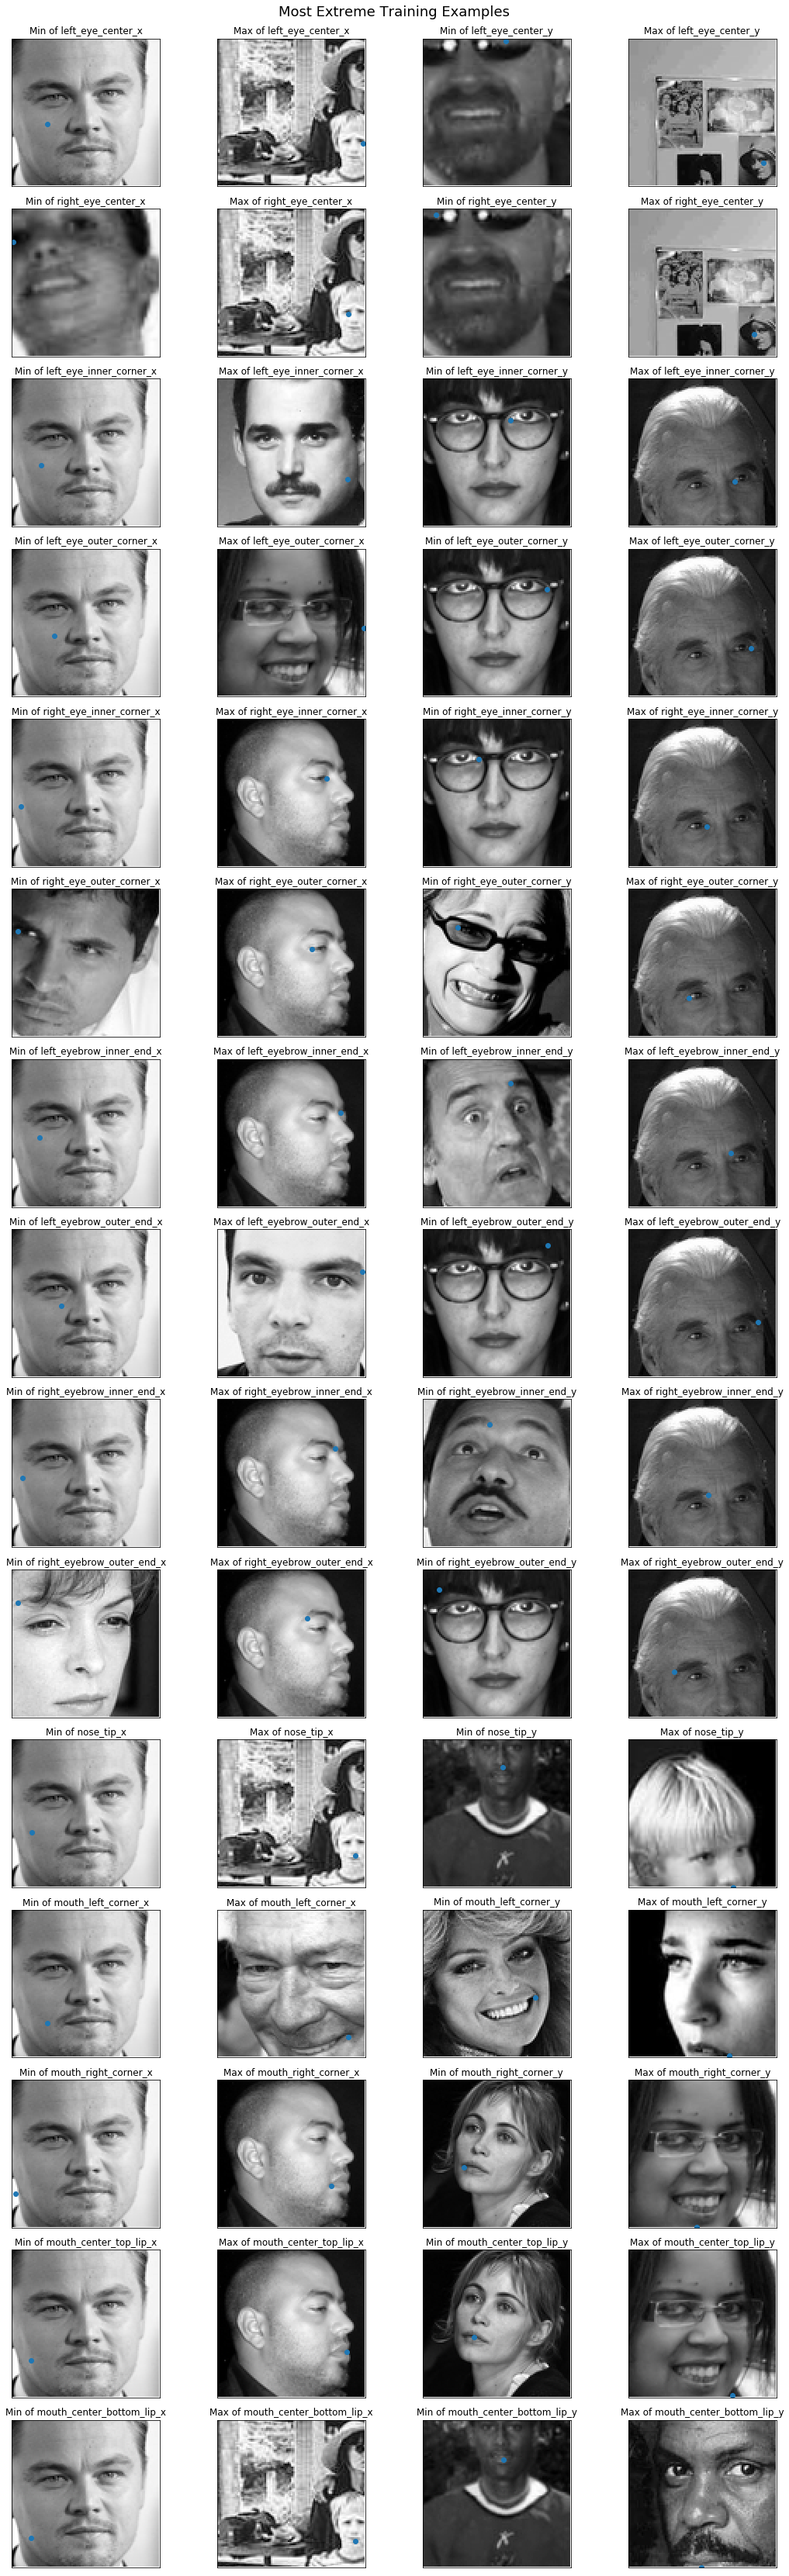

In [6]:
fig, axes = plt.subplots(int(range_df.shape[0]/4),4,
                         figsize=(15,range_df.shape[0]),
                         sharex=True, sharey=True,
                         subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()
c = -2
for i, image in enumerate(range_df.Image):
    axes[i].set_ylim(96,0)
    axes[i].set_xlim(0,96)
    axes[i].imshow(np.reshape(image,(96,96)), origin='upper', cmap='gray')
    
    if i %4 ==0: 
        c+=2
    axes[i].scatter(x=range_df.iloc[i, c],
                    y=range_df.iloc[i, c+1])
    if i % 2 == 0:
        axes[i].set_title('Min of {}'.format(range_df.columns[int(i/2)]))
    else:
        axes[i].set_title('Max of {}'.format(range_df.columns[int(i/2)]))
# Adjust some of the spacing between the subplots
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.15, wspace=0.2)
    fig.suptitle("Most Extreme Training Examples", fontsize=18, y=0.89)

## Freaking Leo
Looks like Leo's data is all messed up based on the plot above. Let's look at all of his data to see if any of it is salvageable. To do this, we find Leo's index in the dataframe. It is 3563. So let's look at that in more detail.

left_eye_center_x                                                      22.7633
left_eye_center_y                                                      55.6172
right_eye_center_x                                                     1.52853
right_eye_center_y                                                      56.405
left_eye_inner_corner_x                                                 19.065
left_eye_inner_corner_y                                                56.2912
left_eye_outer_corner_x                                                27.5719
left_eye_outer_corner_y                                                56.3844
right_eye_inner_corner_x                                               5.75105
right_eye_inner_corner_y                                               56.7439
right_eye_outer_corner_x                                                   NaN
right_eye_outer_corner_y                                                   NaN
left_eyebrow_inner_end_x                            

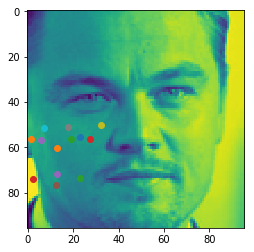

In [40]:
mini_df = df.iloc[3563]
plt.imshow(
    np.reshape(
        np.array([int(x)/255 for x in mini_df['Image'].split()]),
        (96,96)))
plt.scatter(mini_df.left_eye_center_x, mini_df.left_eye_center_y)
plt.scatter(mini_df.right_eye_center_x, mini_df.right_eye_center_y)
plt.scatter(mini_df.left_eye_inner_corner_x, mini_df.left_eye_inner_corner_y)
plt.scatter(mini_df.left_eye_outer_corner_x, mini_df.left_eye_outer_corner_y)
plt.scatter(mini_df.right_eye_inner_corner_x, mini_df.right_eye_inner_corner_y)
plt.scatter(mini_df.right_eye_outer_corner_x, mini_df.right_eye_outer_corner_y)
plt.scatter(mini_df.right_eye_outer_corner_x, mini_df.right_eye_outer_corner_y)
plt.scatter(mini_df.left_eyebrow_inner_end_x, mini_df.left_eyebrow_inner_end_y)
plt.scatter(mini_df.left_eyebrow_outer_end_x, mini_df.left_eyebrow_outer_end_y)
plt.scatter(mini_df.right_eyebrow_inner_end_x, mini_df.right_eyebrow_inner_end_y)
plt.scatter(mini_df.right_eyebrow_outer_end_x, mini_df.right_eyebrow_outer_end_y)
plt.scatter(mini_df.nose_tip_x, mini_df.nose_tip_y)
plt.scatter(mini_df.mouth_left_corner_x, mini_df.mouth_left_corner_y)
plt.scatter(mini_df.mouth_right_corner_x, mini_df.mouth_right_corner_y)
plt.scatter(mini_df.mouth_center_top_lip_x, mini_df.mouth_center_top_lip_y)
plt.scatter(mini_df.mouth_center_bottom_lip_x, mini_df.mouth_center_bottom_lip_y)
mini_df

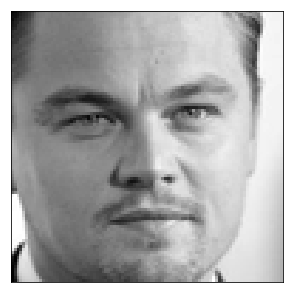

In [41]:
fig, ax = plt.subplots(1,1, figsize=(5,5),  subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(
    np.reshape(
        np.array([int(x)/255 for x in mini_df['Image'].split()]),
        (96,96)), cmap='gray')

## Leo Continued
Oh boy, it looks like all of Leo's data is in our lower left quadrant. That doesn't seem right. It could be a scaling issue. But for now we will assume the presence of Leo in our dataset will not tip the accuracy scales in our favor. So we will remove him, and repeat our plotting of the extreme values.

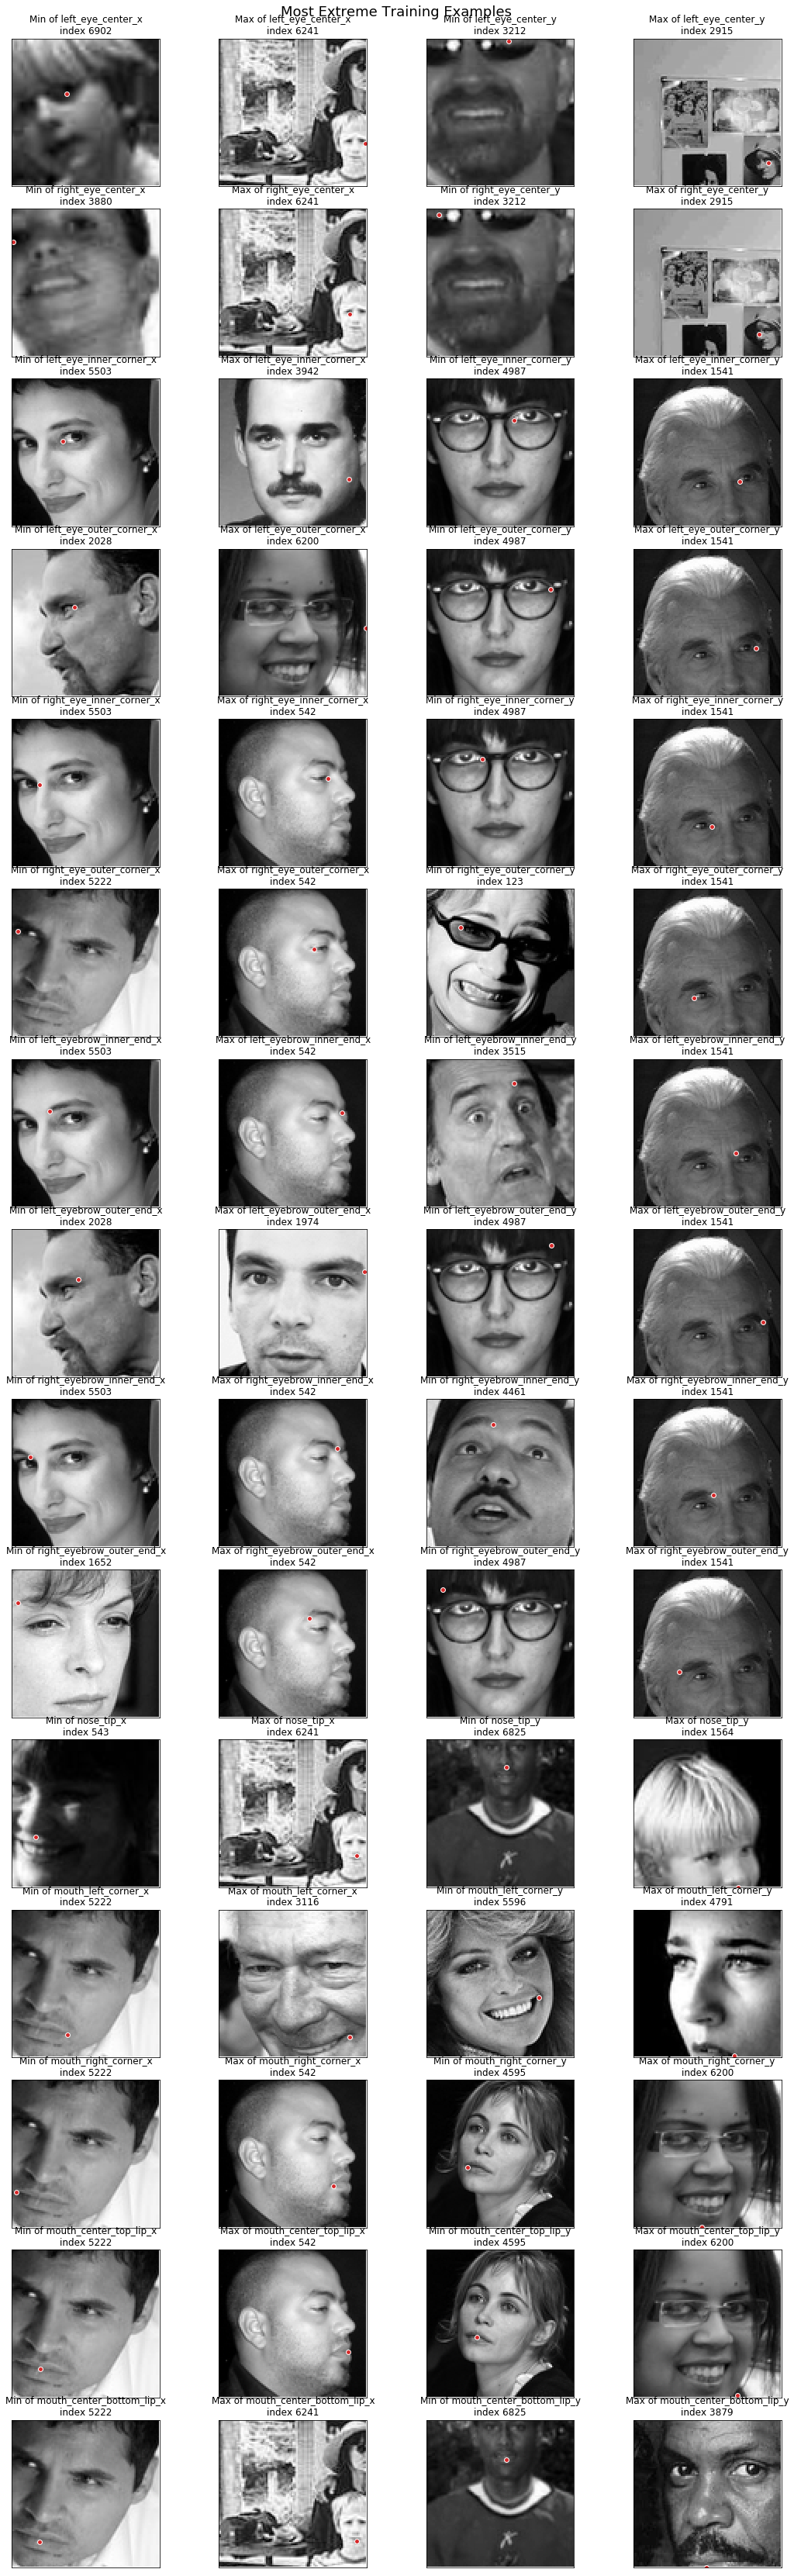

In [42]:
# Drop Leo from the original dataframe and let's try this again
range_df = pd.DataFrame()
df_noleo = df.drop(3563).reset_index(drop=True)

# We now loop over the dataframe without Leo and hope we don't uncover any more erroneous data
for col in df.columns[:-1]:
    range_df = pd.concat([range_df,
                          pd.DataFrame(df_noleo.iloc[df_noleo[col].idxmin()]).T,
                          pd.DataFrame(df_noleo.iloc[df_noleo[col].idxmax()]).T])

range_df['Image'] = range_df['Image'].map(lambda x: np.array(x.split()).astype(int) / 255.0)
fig, axes = plt.subplots(int(range_df.shape[0]/4),4,
                         figsize=(15,range_df.shape[0]),
                         sharex=True, sharey=True,
                         subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()
c = -2
for i, image in enumerate(range_df.Image):
    axes[i].set_ylim(96,0)
    axes[i].set_xlim(0,96)
    axes[i].imshow(np.reshape(image,(96,96)), origin='upper', cmap='gray')
    
    if i %4 ==0: 
        c+=2
    axes[i].scatter(x=range_df.iloc[i, c],
                    y=range_df.iloc[i, c+1],
                   s=35, c = 'tab:red', edgecolors='white')
    if i % 2 == 0:
        axes[i].set_title('Min of {}\nindex {}'.format(range_df.columns[int(i/2)],
                                                       range_df.iloc[i:i+1].index[0]))
    else:
        axes[i].set_title('Max of {}\nindex {}'.format(range_df.columns[int(i/2)],
                                                       range_df.iloc[i:i+1].index[0]))
# Adjust some of the spacing between the subplots
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.15, wspace=0.25)
    fig.suptitle("Most Extreme Training Examples", fontsize=18, y=0.89)

## Mustachioed Fellow
Without Leo, are plot of the extreme values looks a lot better. However, the Max of left_eye_inner_corner_x seems off judging by our plot. We also notice that index 6200 also seems off. We will drop these two images as well.

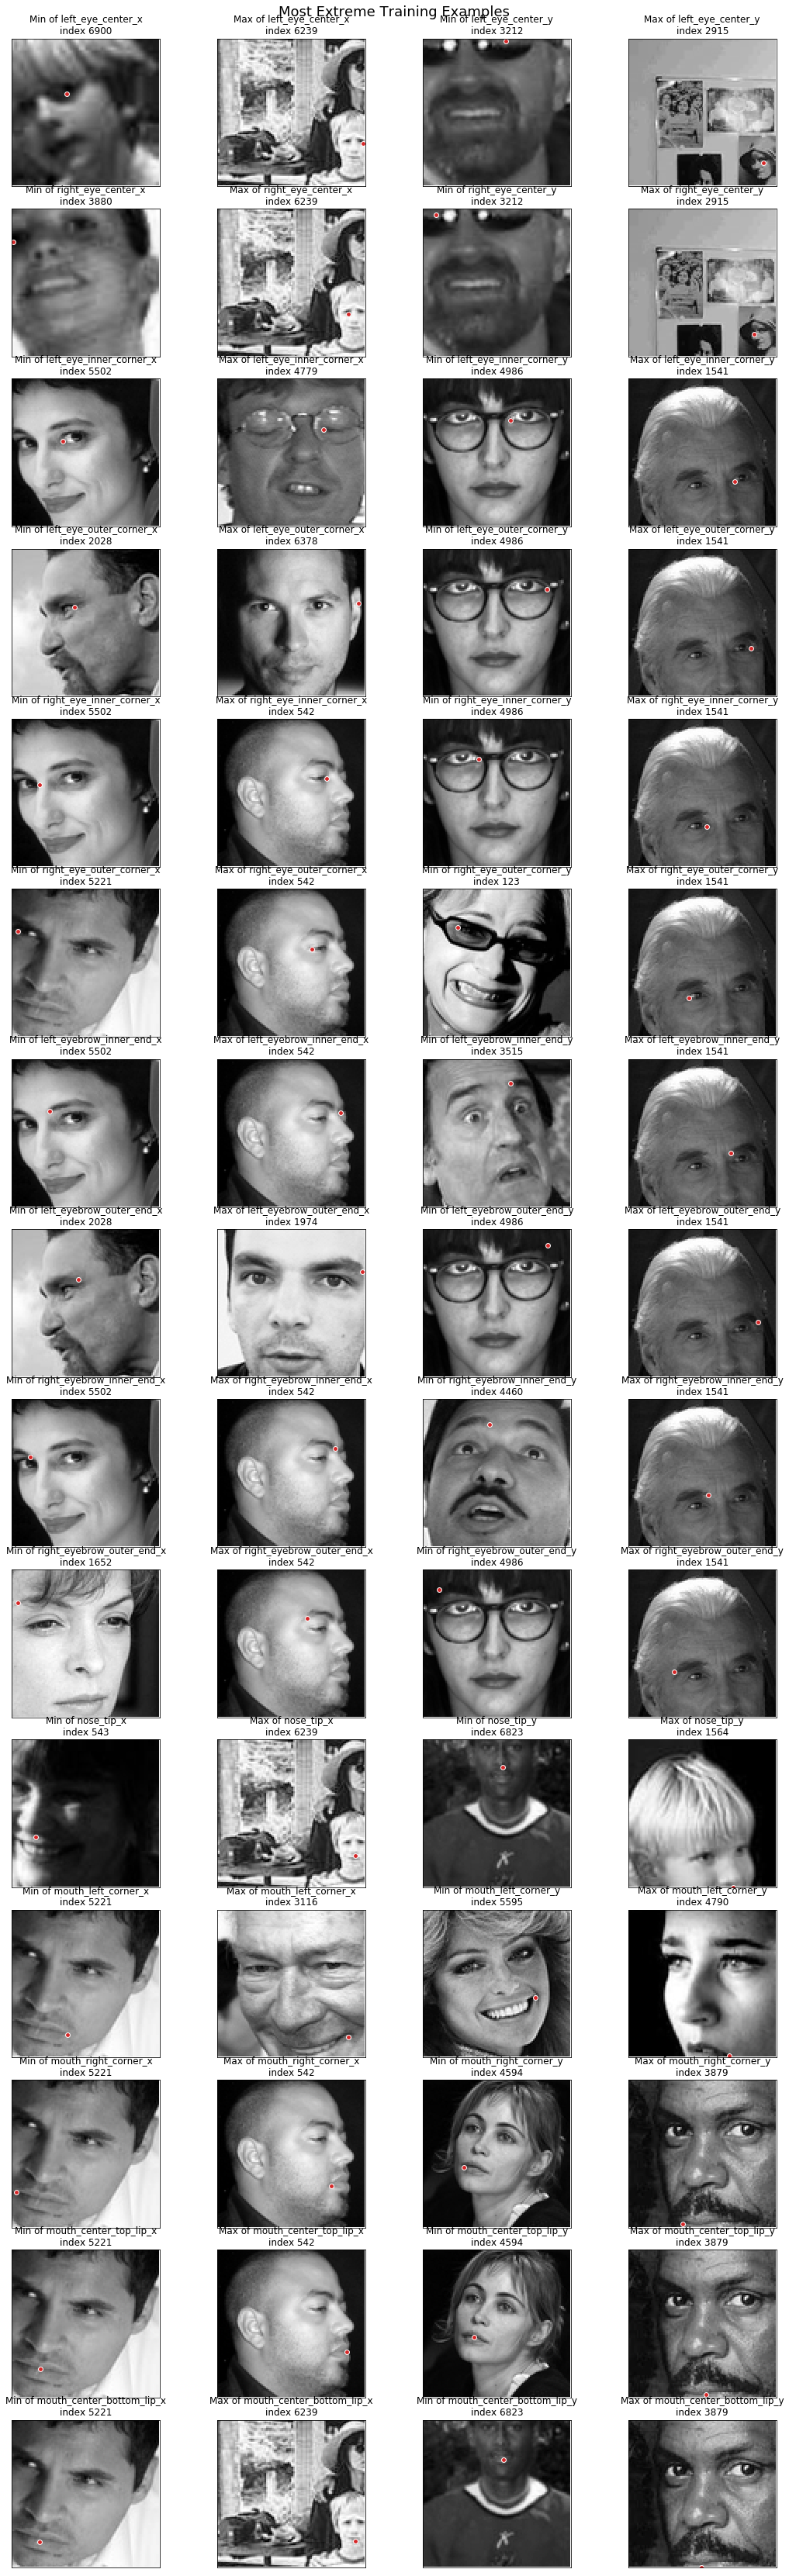

In [43]:
# Create a mini-dataframe with only the most extreme facial keypoints
range_df = pd.DataFrame()
df_nostache = df_noleo.drop([3942,6200]).reset_index(drop=True)
for col in df.columns[:-1]:
    range_df = pd.concat([range_df,
                          pd.DataFrame(df_nostache.iloc[df_nostache[col].idxmin()]).T,
                          pd.DataFrame(df_nostache.iloc[df_nostache[col].idxmax()]).T])

range_df['Image'] = range_df['Image'].map(lambda x: np.array(x.split()).astype(int) / 255.0)
fig, axes = plt.subplots(int(range_df.shape[0]/4),4,
                         figsize=(15,range_df.shape[0]),
                         sharex=True, sharey=True,
                         subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()
c = -2
for i, image in enumerate(range_df.Image):
    axes[i].set_ylim(96,0)
    axes[i].set_xlim(0,96)
    axes[i].imshow(np.reshape(image,(96,96)), origin='upper', cmap='gray')
    
    if i %4 ==0: 
        c+=2
    axes[i].scatter(x=range_df.iloc[i, c],
                    y=range_df.iloc[i, c+1],
                   s=35, c = 'tab:red', edgecolors='white')
    if i % 2 == 0:
        axes[i].set_title('Min of {}\nindex {}'.format(range_df.columns[int(i/2)],
                                                       range_df.iloc[i:i+1].index[0]))
    else:
        axes[i].set_title('Max of {}\nindex {}'.format(range_df.columns[int(i/2)],
                                                       range_df.iloc[i:i+1].index[0]))
# Adjust some of the spacing between the subplots
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.15, wspace=0.2)
    fig.suptitle("Most Extreme Training Examples", fontsize=18, y=0.89)

In [11]:
df_nostache.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,71.079000,39.584208,26.331576,38.054388,NaN,NaN,NaN,NaN,NaN,NaN,...,69.798240,NaN,NaN,NaN,NaN,NaN,NaN,46.984200,81.271920,106 83 74 78 85 87 82 77 72 68 66 65 66 68 75 ...
1,64.399591,38.503814,29.440197,39.945433,NaN,NaN,NaN,NaN,NaN,NaN,...,63.732223,NaN,NaN,NaN,NaN,NaN,NaN,48.181306,75.265206,24 21 17 15 14 11 7 9 13 20 26 29 29 26 27 30 ...
2,69.260800,40.359393,28.490869,36.186097,NaN,NaN,NaN,NaN,NaN,NaN,...,75.671945,NaN,NaN,NaN,NaN,NaN,NaN,45.184110,84.981572,49 50 51 49 48 47 47 47 47 49 51 54 68 90 98 1...
3,73.352348,38.401461,32.468452,38.401461,NaN,NaN,NaN,NaN,NaN,NaN,...,76.604661,NaN,NaN,NaN,NaN,NaN,NaN,49.894330,88.668730,199 203 212 209 185 162 133 111 111 111 111 11...
4,65.515296,36.871904,29.650475,40.187136,NaN,NaN,NaN,NaN,NaN,NaN,...,66.106251,NaN,NaN,NaN,NaN,NaN,NaN,52.254357,77.558827,56 48 34 24 20 19 20 24 32 43 59 82 111 135 15...


## Moving On
Alright, it looks like at least we have our ranges properly bounded. For our next step, let's plot the average value for each keypoint and also look at the distributions of the keypoint data. We will do this visually through the creation of an iteractive plot. That allows us to pick different features to view.

In [44]:
image_options = widgets.IntSlider(
    value=0,
    min=0,
    max=df_nostache.shape[0],
    step=1,
    description='Pick an Image:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

def show_average_keypoint(keypoint=[c[:-2] for c in df_nostache.columns[:-1:2]],
                          im = image_options, marker='o v ^ < > s p * h H D d P X'.split()):
        temp_pic = np.array([int(x)/255 for x in df_nostache.Image[im].split()])
        fig, ax = plt.subplots(1,1,figsize=(10,10),
                         subplot_kw={'xticks': [], 'yticks': []} )
        ax.imshow(np.reshape(temp_pic,(96,96)), origin='upper', cmap='gray')
        ax.scatter(x=df_nostache[keypoint+'_x'], y=df_nostache[keypoint+'_y'],
                  s=40, c='tab:orange', edgecolors='white', marker='x', alpha=0.5)
        ax.scatter(x=df_nostache[keypoint+'_x'].mean(), y=df_nostache[keypoint+'_y'].mean(),
                  s=150, c='tab:red', edgecolors='white', marker=marker)

interact_manual(show_average_keypoint)
print()

interactive(children=(Dropdown(description='keypoint', options=('left_eye_center', 'right_eye_center', 'left_e…

In [45]:
df_nostache.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

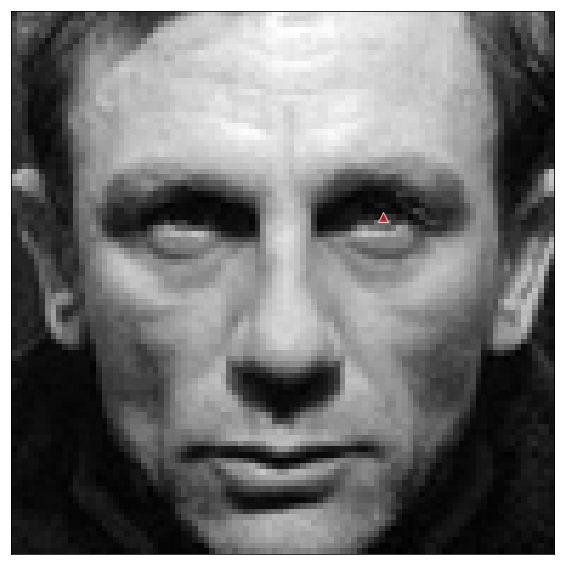

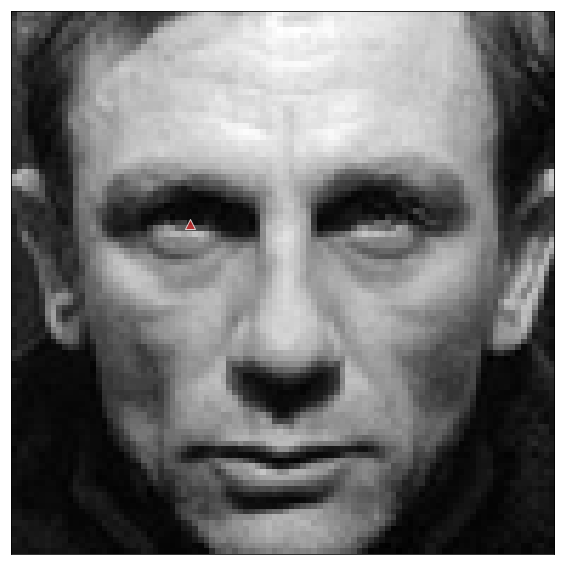

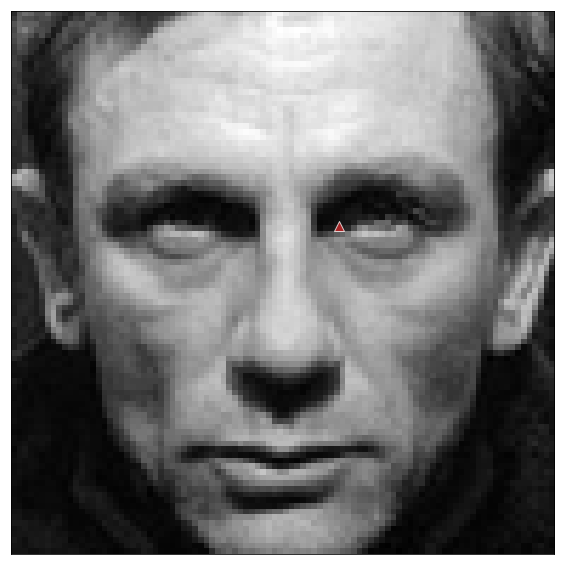

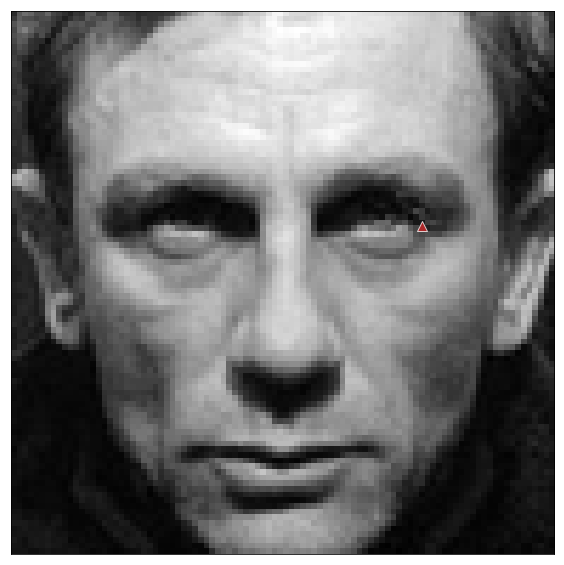

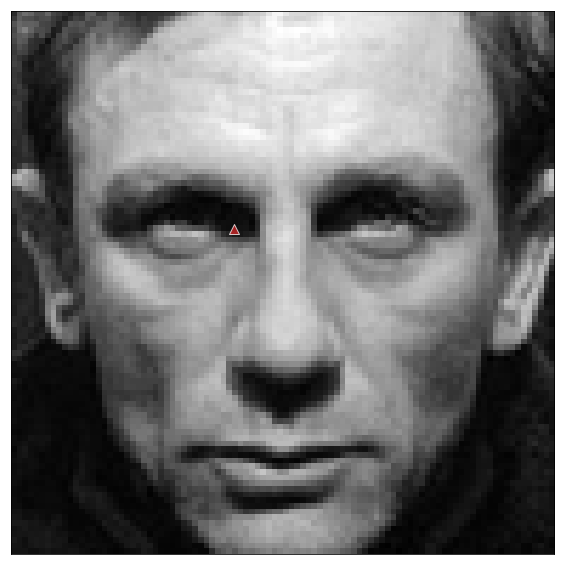

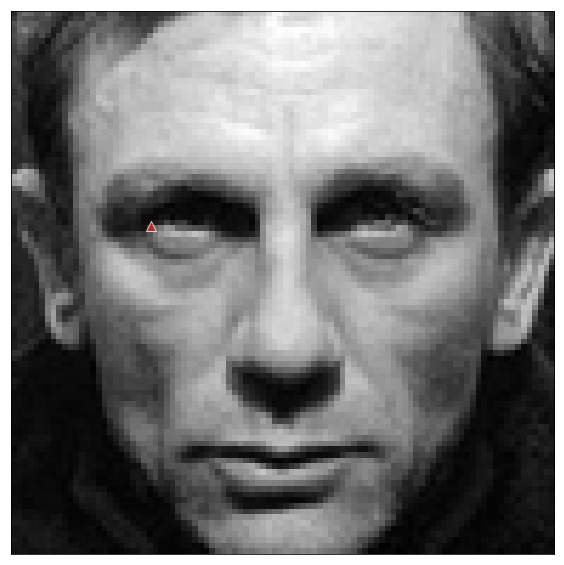

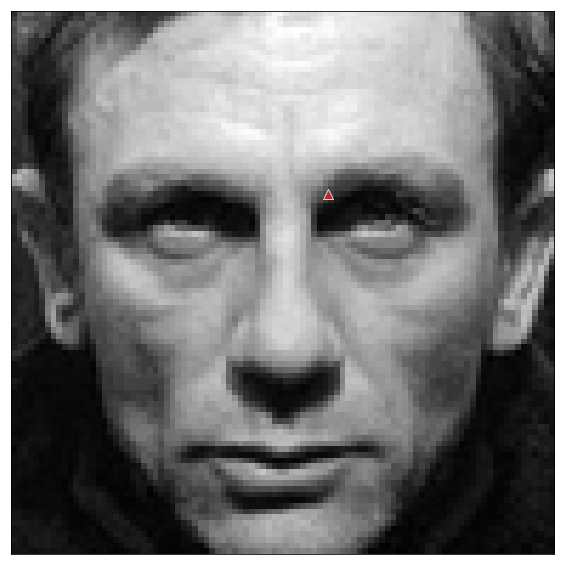

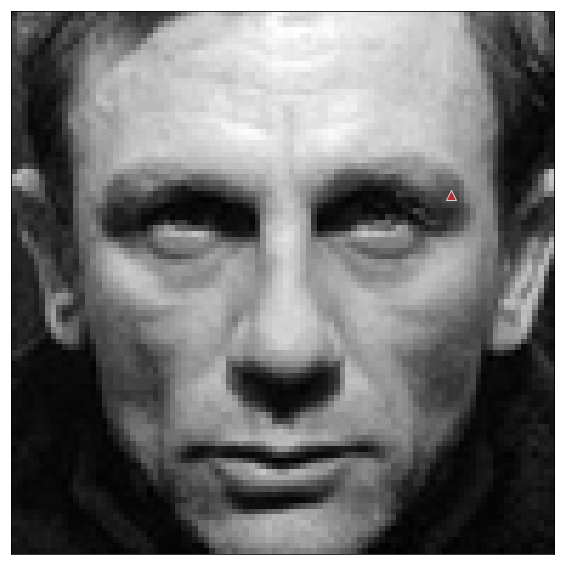

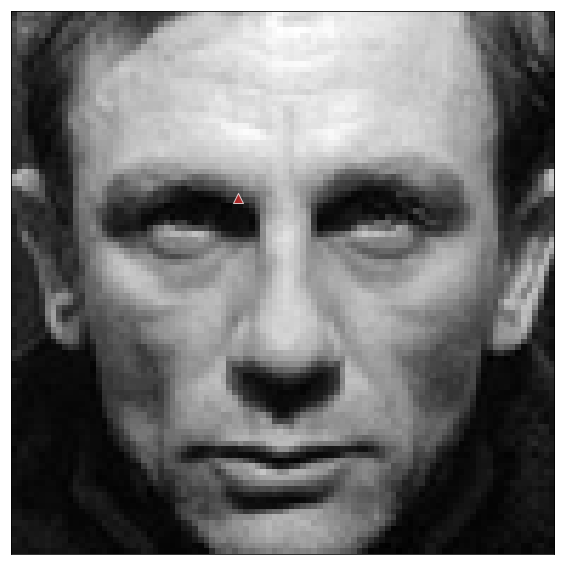

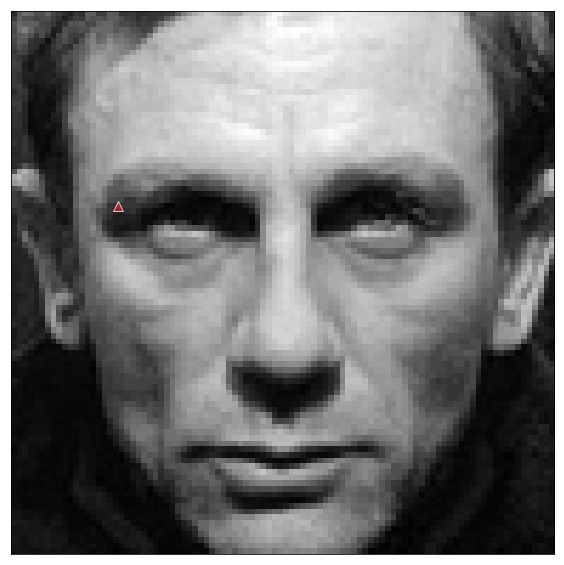

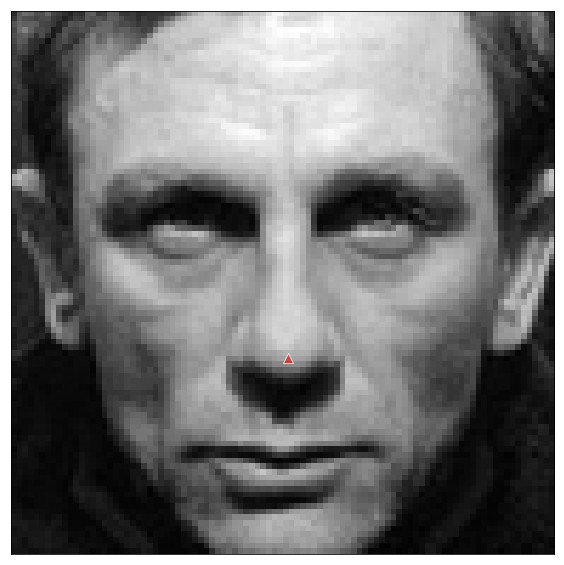

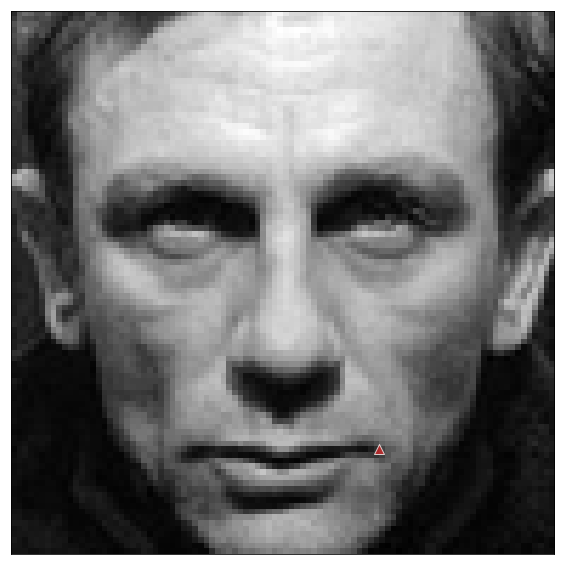

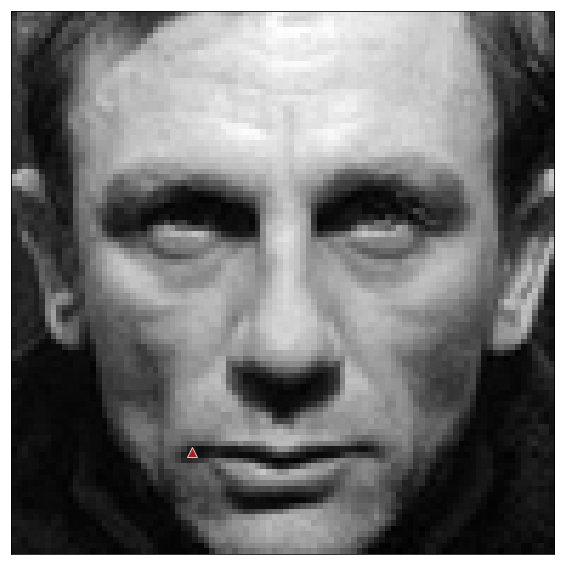

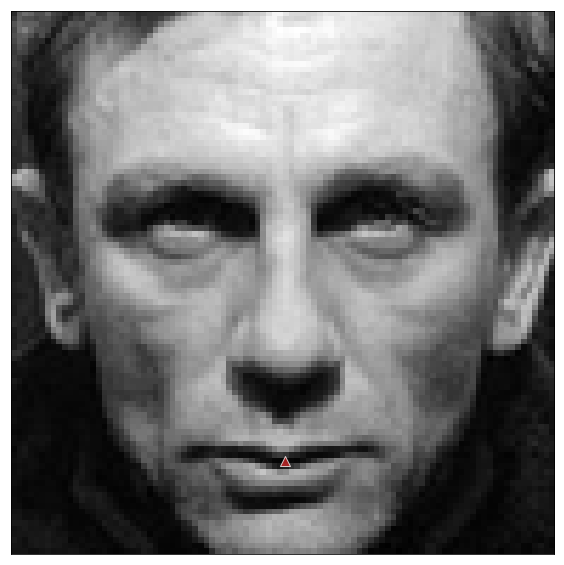

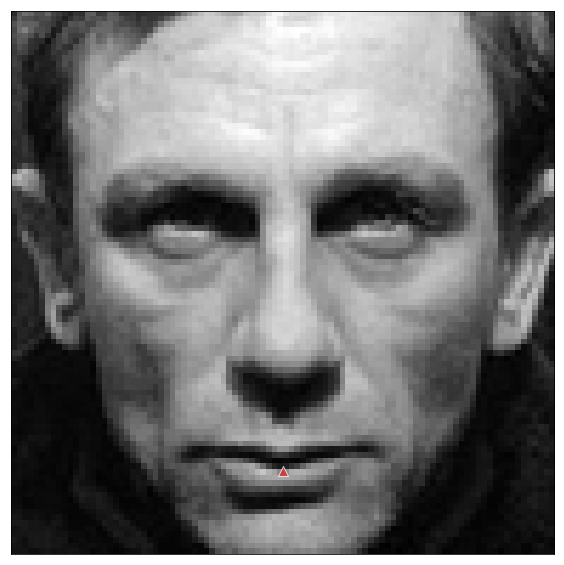

In [14]:
# Use this for building plots for presentation
i = 4557
cols = df_nostache.columns
for col in cols[:-1:2]:
    fig, ax = plt.subplots(1,1,figsize=(10,10),
             subplot_kw={'xticks': [], 'yticks': []} )
    temp_pic = np.array([int(x)/255 for x in df_nostache.Image[i].split()])
    ax.imshow(np.reshape(temp_pic,(96,96)), origin='upper', cmap='gray')
    ax.scatter(x=df_nostache[col][i], y=df_nostache[col[:-1]+'y'][i],
                      s=100, c='tab:red', edgecolors='white', marker='^', alpha=0.75)
    fig.savefig("dcraig_"+col+".png")

## Separate Training and Development Data and Normalize Image Data
We have no assessed our training data and it is time to separate training data from development data so that we can tune our hyperparameters as necessary as we build various models.

In [46]:
# Store the dataframe with and without nans for easier loading. Also convert the images before store
# Data in the image column is space separated strings - convert to int then normalize to the scale of 0 to 1
df_nostache['Image'] = df_nostache['Image'].map(lambda x: np.array(x.split()).astype(int) / 255.0)
df_nostache.to_pickle('df_nostache.pkl')
df_nostache_nonan = df_nostache.dropna().reset_index(drop=True)
df_nostache_nonan = df_nostache_nonan.to_pickle('df_nostache_nonan.pkl')

In [47]:
# Split images into training/dev sets - test set separated
train_X = df_nostache.iloc[:-1000,-1]
train_Y = df_nostache.iloc[:-1000,:-1]
dev_X = df_nostache.iloc[-1000:,-1] 
dev_Y = df_nostache.iloc[-1000:,:-1]

# 
print("Training data consist of {} examples".format(train_X.shape))
print("Training labels consist of {} labels".format(train_Y.shape))
print("Development data consist of {} examples".format(dev_X.shape))
print("Development labels consists of {} labels".format(dev_Y.shape))

Training data consist of (6046,) examples
Training labels consist of (6046, 30) labels
Development data consist of (1000,) examples
Development labels consists of (1000, 30) labels


## The model building begins
Alright. Now we have our data separated and it is time to determine what to use as our baseline model. We will compare against this model to determine how various models can improve accuracy of predictions.

## The Baseline Model
The baseline model will simply be the average value of each feature. This is highly simplistic and won't be very accurate, but it should provide us with ample room to improve.

### Scoring
Per the Kaggle Competition instructions, scores are judged based on the Root Mean Squared Error given by the equation below.
$$RMSE = \sqrt{\frac{1}{n}\cdot\sum\limits_{i=1}^{n}(y-\hat{y})^2}$$

In [48]:
# Create a dictionary to keep the scores of our various models
score_dict = {}

# This is our scoring function. it can be passed a single label or all the labels
def rmse_func(predictions, actuals):
    return np.sqrt(np.nanmean((actuals-predictions)**2))

# Baseline predictions for each keypoint is simply the mean of the training data
bl_predictions = train_Y.mean(axis=0, skipna=True)

# How did we do?
print("Baseline Score is: {:.6f}".format(rmse_func(bl_predictions, dev_Y)))

# Add the baseline score to the dictionary
score_dict['baseline'] = rmse_func(bl_predictions, dev_Y)

# Add the subcomponents of the baseline score to the dictionary
for p, pred in enumerate(bl_predictions):
    print("Baseline Score for {} is: {:.6f}".format(dev_Y.columns[p], rmse_func(pred, dev_Y.iloc[:,p])))
    score_dict['baseline_'+dev_Y.columns[p]] = rmse_func(pred, dev_Y.iloc[:,p])
    


Baseline Score is: 3.836694
Baseline Score for left_eye_center_x is: 3.558489
Baseline Score for left_eye_center_y is: 3.244828
Baseline Score for right_eye_center_x is: 3.328591
Baseline Score for right_eye_center_y is: 3.093223
Baseline Score for left_eye_inner_corner_x is: 1.836153
Baseline Score for left_eye_inner_corner_y is: 2.100768
Baseline Score for left_eye_outer_corner_x is: 2.873846
Baseline Score for left_eye_outer_corner_y is: 3.058975
Baseline Score for right_eye_inner_corner_x is: 2.013249
Baseline Score for right_eye_inner_corner_y is: 1.951474
Baseline Score for right_eye_outer_corner_x is: 2.882246
Baseline Score for right_eye_outer_corner_y is: 2.776779
Baseline Score for left_eyebrow_inner_end_x is: 2.583136
Baseline Score for left_eyebrow_inner_end_y is: 2.755936
Baseline Score for left_eyebrow_outer_end_x is: 3.208914
Baseline Score for left_eyebrow_outer_end_y is: 3.972520
Baseline Score for right_eyebrow_inner_end_x is: 2.724708
Baseline Score for right_eyebrow

In [50]:
bl_predictions.to_csv('Submissions/baseline_predictions.csv')

/Users/tom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Baseline Score
Our baseline score (printed above) was calculated to be 3.83 using our highly simplistic technique. We can only improve from here, right? We know that for image recognition neural nets are going to be our go to choice. However, before we jump into the complexity of that, let's try a few simpler methods to determine how much better we can do than the simplistic baseline without resorting to a NN.


## k-Nearest Neighbors - Regressor
We will first try k-NN, but we don't really expect this to be a great option as we have 9216 different features (pixels). We also have many training images that don't have all of the keypoints in them. What are we going to do about that.

Let's try four unique methods to start.  
1. kNN Model using only the examples from the training set that have all of the features. We know this will be an issue after viewing some of the images because some images only show partial faces. Thus assuming all test data will have all keypoints is likely to be erroneous. Since we have continuous results, we use the regressor in order to average the values of the nearest k points. 
2. Build a model using all traing data - this may actually require building 15 separate models in which the training data is trimmed to match the extent of the labels that we have for each keypoint.
3. Try the same model as 1 above but use the radius model (average all points within a radius)
4. Try the same model as 2 above but use the radius model (average all points within a radius)

In [43]:
# Let's start with model knn1 - we will need to subset our training data to just get the rows with all of the values
train_Y_no_nan = train_Y.dropna()

# Now let's reduce our image data as well
train_X_no_nan = train_X.loc[train_Y_no_nan.index]

# Reduce the development set by removing NaNs
dev_Y_no_nan = dev_Y.dropna()

# Now let's reduce our image data as well
dev_X_no_nan = dev_X.loc[dev_Y_no_nan.index]

# Let's Re-baseline to the no-nan dataset
# Baseline predictions for each keypoint is simply the mean of the training data
bl_predictions = train_Y_no_nan.mean(axis=0, skipna=True)

# How did we do?
print("Baseline Score is: {:.6f}".format(rmse_func(bl_predictions, dev_Y_no_nan)))

# Add the baseline score to the dictionary
score_dict['baseline'] = rmse_func(bl_predictions, dev_Y)

# Add the subcomponents of the baseline score to the dictionary
for p, pred in enumerate(bl_predictions):
    print("Baseline Score for {} is: {:.6f}".format(dev_Y.columns[p], rmse_func(pred, dev_Y.iloc[:,p])))
    score_dict['baseline_'+dev_Y.columns[p]] = rmse_func(pred, dev_Y.iloc[:,p])

# Get the keypoints into an array
X = np.array([[i for i in x] for x in train_X_no_nan]).astype('float32')
y = train_Y_no_nan.values.astype('float32')
dev_X_no_nan = np.array([[i for i in x] for x in dev_X_no_nan]).astype('float32')
dev_Y_no_nan = dev_Y_no_nan.values.astype('float32')

# Let's see the difference in dataset size
print("Removing rows with NaNs yields {} total training examples.".format(len(train_Y_no_nan)))
print("We originally had {} total examples in our training set.".format(len(train_Y)))
print("Removing rows with NaNs yields {} total dev examples.".format(len(dev_Y_no_nan)))
print("We originally had {} total examples in our dev set.".format(len(dev_Y)))

Baseline Score is: 3.160188
Baseline Score for left_eye_center_x is: 3.561208
Baseline Score for left_eye_center_y is: 3.322376
Baseline Score for right_eye_center_x is: 3.388722
Baseline Score for right_eye_center_y is: 3.217574
Baseline Score for left_eye_inner_corner_x is: 1.837178
Baseline Score for left_eye_inner_corner_y is: 2.094993
Baseline Score for left_eye_outer_corner_x is: 2.873158
Baseline Score for left_eye_outer_corner_y is: 3.052959
Baseline Score for right_eye_inner_corner_x is: 2.013588
Baseline Score for right_eye_inner_corner_y is: 1.950311
Baseline Score for right_eye_outer_corner_x is: 2.883472
Baseline Score for right_eye_outer_corner_y is: 2.777037
Baseline Score for left_eyebrow_inner_end_x is: 2.582206
Baseline Score for left_eyebrow_inner_end_y is: 2.753755
Baseline Score for left_eyebrow_outer_end_x is: 3.201179
Baseline Score for left_eyebrow_outer_end_y is: 3.972680
Baseline Score for right_eyebrow_inner_end_x is: 2.722820
Baseline Score for right_eyebrow

In [44]:
# Create an array of k-values to try
kvalues = [1,3,5,7,9,11,13,21,31]

print(50*"=")
print("Assessment of K-values for KNN without Nans")
print(50*"=" + "\n")
for k in kvalues:
    # Let's create our knn classifier
    knn_no_nan = KNeighborsRegressor(n_neighbors=k)
    
    # Fit the model
    knn_no_nan.fit(X, y)
    
    # Generate predictions and time this
    start_predict = time.time()
    knn_predictions = knn_no_nan.predict(dev_X_no_nan)
    end_predict = time.time()
    
    # Display Summary Information
    print("k-value: {}\tRSME: {:.4f}\t Prediction Time: {:.2f} sec".format(
        k, rmse_func(knn_predictions, dev_Y_no_nan), (end_predict - start_predict)))

    

Assessment of K-values for KNN without Nans

k-value: 1	RSME: 2.7140	 Prediction Time: 12.99 sec
k-value: 3	RSME: 2.5053	 Prediction Time: 13.38 sec
k-value: 5	RSME: 2.4855	 Prediction Time: 14.41 sec
k-value: 7	RSME: 2.5127	 Prediction Time: 13.78 sec
k-value: 9	RSME: 2.5377	 Prediction Time: 13.92 sec
k-value: 11	RSME: 2.5541	 Prediction Time: 13.29 sec
k-value: 13	RSME: 2.5775	 Prediction Time: 13.52 sec
k-value: 21	RSME: 2.6289	 Prediction Time: 13.94 sec
k-value: 31	RSME: 2.6994	 Prediction Time: 12.99 sec


In [46]:
# Create an array of k-values to try
rvalues = [7.0,8.0,9.0,10.0,11,12,13,14,15]

print(50*"=")
print("Assessment of K-values for RNN without Nans")
print(50*"=" + "\n")
for r in rvalues:
    # Let's create our knn classifier
    rnn_no_nan = RadiusNeighborsRegressor(radius=r)
    
    # Fit the model
    rnn_no_nan.fit(X, y)
    
    # Generate predictions and time this
    start_predict = time.time()
    rnn_predictions = rnn_no_nan.predict(dev_X_no_nan)
    end_predict = time.time()
    
    # Convert to dataframe
    rnn_df = pd.DataFrame(rnn_predictions)
    
    # Back Fill NA predictions with training set means
    rnn_df.columns = bl_predictions.index
    rnn_df = rnn_df.fillna(value=bl_predictions)
    
    # Display Summary Information
    print("R-value: {}\tRSME: {:.4f}\t Prediction Time: {:.2f} sec".format(
        r, rmse_func(np.array(rnn_df), dev_Y_no_nan), (end_predict - start_predict)))


Assessment of K-values for RNN without Nans



/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 7.0	RSME: 2.9527	 Prediction Time: 19.04 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 8.0	RSME: 2.8507	 Prediction Time: 18.73 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 9.0	RSME: 2.7596	 Prediction Time: 19.74 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 10.0	RSME: 2.7151	 Prediction Time: 19.77 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 11	RSME: 2.6861	 Prediction Time: 19.70 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 12	RSME: 2.6752	 Prediction Time: 19.74 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 13	RSME: 2.6763	 Prediction Time: 22.02 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


R-value: 14	RSME: 2.6803	 Prediction Time: 25.69 sec
R-value: 15	RSME: 2.7155	 Prediction Time: 19.56 sec


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


## Let's transform our training data to include horizontal flips first. If that is successful, we will try rotations as well.

In [21]:
df_nostache_nonan = df_nostache.dropna().reset_index(drop=True)


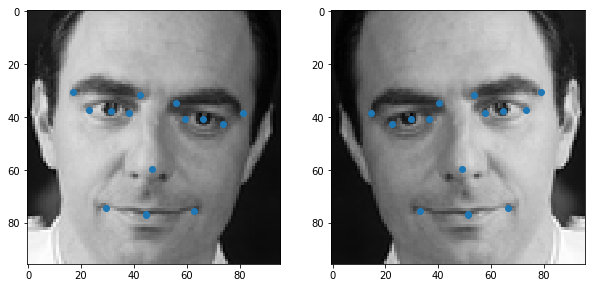

In [25]:
# Make a copy of the dataframe
df_nostache_nonan_xflip = df_nostache_nonan.copy()

# Flip the Image data across the columns
df_nostache_nonan_xflip.Image = df_nostache_nonan_xflip.Image.map(lambda x: x.reshape(96,96)[:,::-1])

# Flip the x-coordinates of our keypoints by subtracting from 96
for column in df_nostache_nonan_xflip.columns[:-1]:
    if column[-2:] == '_x':
        df_nostache_nonan_xflip[column] = df_nostache_nonan_xflip[column].map(lambda x: 96.0-x)
        
# Last item is to swap the left/right column names
new_columns = ['right_eye_center_x', 'right_eye_center_y', 'left_eye_center_x',
       'left_eye_center_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_left_corner_x',
       'mouth_left_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image']

df_nostache_nonan_xflip.columns = new_columns
df_nostache_nonan_xflip = df_nostache_nonan_xflip.reindex(columns = [col for col in df_nostache_nonan.columns])

fig, axes = plt.subplots(1,2, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(df_nostache_nonan_xflip.Image[25], origin='upper', cmap='gray')
axes[0].scatter(x=df_nostache_nonan_xflip.iloc[25,0:-1:2],y=df_nostache_nonan_xflip.iloc[25,1:-1:2])

axes[1].imshow(df_nostache_nonan.Image[25].reshape(96,96), origin='upper', cmap='gray')
axes[1].scatter(x=df_nostache_nonan.iloc[25,0:-1:2],y=df_nostache_nonan.iloc[25,1:-1:2])

# Grab 100% of the flipped data
df_nostache_nonan_xflip = df_nostache_nonan_xflip.sample(frac=1.0).reset_index(drop=True)
df_nostache_nonan_w_xflip = pd.concat([df_nostache_nonan, df_nostache_nonan_xflip])

# Shuffle the flipped/not flipped data
df_nostache_nonan_w_xflip = df_nostache_nonan_w_xflip.sample(frac=1.0).reset_index(drop=True)

# Save the data
df_nostache_nonan_w_xflip.to_pickle('df_nostache_nonan_w_flip.pkl')

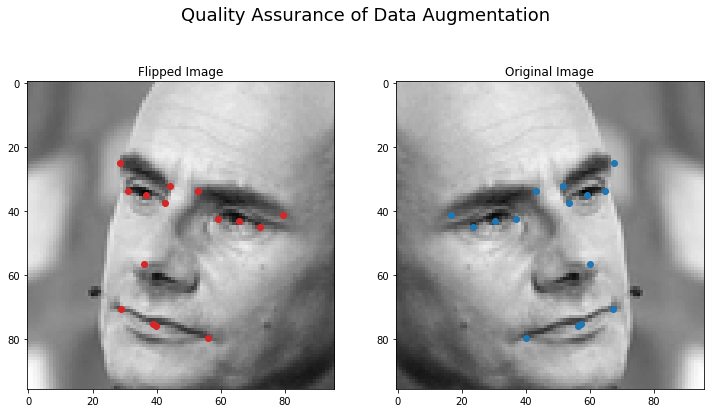

In [34]:
# Make a copy of the dataframe
df_nostache_xflip = df_nostache.copy()

# Flip the Image data across the columns
df_nostache_xflip.Image = df_nostache_xflip.Image.map(lambda x: x.reshape(96,96)[:,::-1])

# Flip the x-coordinates of our keypoints by subtracting from 96
for column in df_nostache_xflip.columns[:-1]:
    if column[-2:] == '_x':
        df_nostache_xflip[column] = df_nostache_xflip[column].map(lambda x: 96.0-x)
        
# Last item is to swap the left/right column names
new_columns = ['right_eye_center_x', 'right_eye_center_y', 'left_eye_center_x',
       'left_eye_center_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_left_corner_x',
       'mouth_left_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image']

df_nostache_xflip.columns = new_columns
df_nostache_xflip = df_nostache_xflip.reindex(columns = [col for col in df_nostache.columns])

# Quality Assurance plots
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(df_nostache_xflip.Image[25], origin='upper', cmap='gray')
axes[0].scatter(x=df_nostache_xflip.iloc[25,0:-1:2],y=df_nostache_xflip.iloc[25,1:-1:2], c='tab:red')
axes[0].set_title("Flipped Image")

axes[1].imshow(df_nostache.Image[25].reshape(96,96), origin='upper', cmap='gray')
axes[1].scatter(x=df_nostache.iloc[25,0:-1:2],y=df_nostache.iloc[25,1:-1:2])
axes[1].set_title("Original Image")

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.15, wspace=0.2)
fig.suptitle("Quality Assurance of Data Augmentation", fontsize=18, y=0.82)

# Grab 100% of the flipped data
df_nostache_xflip = df_nostache_xflip.sample(frac=1.0).reset_index(drop=True)
df_nostache_w_xflip = pd.concat([df_nostache, df_nostache_xflip])

# Shuffle the flipped/not flipped data
df_nostache_w_xflip = df_nostache_w_xflip.sample(frac=1.0).reset_index(drop=True)
df_nostache_w_xflip.to_pickle('df_nostache_w_flip.pkl')